# Packages

In [29]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
import pickle 


# I - Import Data

In [30]:
#import hourly data
df_station_h = pd.read_csv('I:/DS/Air/Data/station_hour.csv')
df_station_h['Datetime'] = pd.to_datetime(df_station_h['Datetime'])
#import daily data
df_2 = pd.read_csv('I:/DS/Air/Data/station_day.csv')
df_2['Date'] = pd.to_datetime(df_2['Date'])

C:\Users\Florian\AppData\Local\Temp\ipykernel_4028\2188549516.py:2: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_station_h = pd.read_csv('I:/DS/Air/Data/station_hour.csv')


In [31]:
#import station info 
df_station = pd.read_csv('I:/DS/Air/Data/stations.csv')

In [32]:
#merge both df
df = df_station_h.merge(df_station, on = "StationId")


# II - EDA

###  A -   Missing values

In [5]:
#check for missing values 

print('Total values =', len(df_station_h),
      '\n missing values for each column:')

display(pd.DataFrame(data=df_station_h.isnull().sum(),columns=['Missing values']).sort_values('Missing values',ascending=False).T)

print(
      ' Proportion of missing values:'
      )
display(pd.DataFrame(data=df_station_h.isnull().sum()/len(df_station_h),columns=['Proportion']).sort_values('Proportion',ascending=False).T)

Total values = 2589083 
 missing values for each column:


,Xylene,NH3,PM10,Toluene,Benzene,SO2,O3,PM2.5,AQI,AQI_Bucket,NO,NO2,CO,NOx,StationId,Datetime
Missing values,2075104,1236618,1119252,1042366,861579,742737,725973,647689,570190,570190,553711,528973,499302,490808,0,0


 Proportion of missing values:


,Xylene,NH3,PM10,Toluene,Benzene,SO2,O3,PM2.5,AQI,AQI_Bucket,NO,NO2,CO,NOx,StationId,Datetime
Proportion,0.801482,0.477628,0.432297,0.4026,0.332774,0.286873,0.280398,0.250162,0.220229,0.220229,0.213864,0.204309,0.192849,0.189568,0.0,0.0


In [33]:
#Xylene and NH3 have more missing values than real ones, filling them would add a huge bias to the model, they won't be taken into account 
df.drop(['Xylene','NH3'],axis=1, inplace=True) #hourly data
df_2.drop(['Xylene','NH3'],axis=1, inplace=True)  #daily data

In [109]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI
count,1.941394e+06,1.469831e+06,2.035372e+06,2.060110e+06,2.098275e+06,2.089781e+06,1.846346e+06,1.863110e+06,1.727504e+06,1.546717e+06,2.018893e+06
mean,8.086481e+01,1.584839e+02,2.278825e+01,3.523689e+01,4.055115e+01,1.502366e+00,1.211602e+01,3.806408e+01,3.305493e+00,1.490266e+01,1.801730e+02
std,8.947618e+01,1.397883e+02,4.846146e+01,3.497508e+01,5.590894e+01,6.292445e+00,1.467385e+01,4.710653e+01,1.214053e+01,3.329729e+01,1.404095e+02
min,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,5.000000e+00
25%,2.816000e+01,6.400000e+01,3.050000e+00,1.310000e+01,1.135000e+01,4.100000e-01,4.250000e+00,1.102000e+01,8.000000e-02,3.400000e-01,8.400000e+01
50%,5.259000e+01,1.162500e+02,7.150000e+00,2.479000e+01,2.286000e+01,8.000000e-01,8.250000e+00,2.475000e+01,9.600000e-01,3.400000e+00,1.310000e+02
75%,9.774000e+01,2.040000e+02,1.858000e+01,4.548000e+01,4.570000e+01,1.380000e+00,1.453000e+01,4.953000e+01,3.230000e+00,1.510000e+01,2.590000e+02
max,1.000000e+03,1.000000e+03,5.000000e+02,4.999900e+02,5.000000e+02,4.985700e+02,1.999600e+02,9.970000e+02,4.980700e+02,4.999900e+02,3.133000e+03


It seems that we have a big difference between maximum values and the 3rd quartile values

<Axes: >

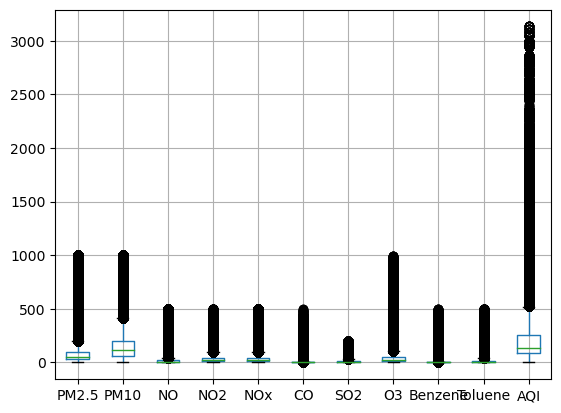

In [8]:
df.boxplot()

Taking into account the strong disparity between the values (high outliers), it's better to use the median value to fill the missing ones. 

In [34]:
#filling missing values with the median 
columns_list = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'CO','SO2', 'O3', 'Benzene', 'Toluene', 'AQI']

for columns in columns_list:
    df[columns] = df[columns].fillna(df[columns].median())
    df_2[columns] = df_2[columns].fillna(df_2[columns].median())

#instead of filling AQI_Bucket with a mode, we calculate it depending on the median values replaced in df.AQI 

def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN
    
    
df['AQI_Bucket'] =  df['AQI'].map(lambda x: get_AQI_bucket(x)) 
df_2['AQI_Bucket'] =  df_2['AQI'].map(lambda x: get_AQI_bucket(x)) 
#copy of the new df 
df_save = df 

df.head()

,StationId,Datetime,PM2.5,PM10,NO,NO2,NOx,CO,SO2,O3,Benzene,Toluene,AQI,AQI_Bucket,StationName,City,State,Status
0,AP001,2017-11-24 17:00:00,60.50,98.00,2.35,30.80,18.25,0.1,11.85,126.40,0.1,6.10,131.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
1,AP001,2017-11-24 18:00:00,65.50,111.25,2.70,24.20,15.07,0.1,13.17,117.12,0.1,6.25,131.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
2,AP001,2017-11-24 19:00:00,80.00,132.00,2.10,25.18,15.15,0.1,12.08,98.98,0.2,5.98,131.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
3,AP001,2017-11-24 20:00:00,81.50,133.25,1.95,16.25,10.23,0.1,10.47,112.20,0.2,6.72,131.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active
4,AP001,2017-11-24 21:00:00,75.25,116.00,1.43,17.48,10.43,0.1,9.12,106.35,0.2,5.75,131.0,Moderate,"Secretariat, Amaravati - APPCB",Amaravati,Andhra Pradesh,Active


### B - Data Viz

C:\Users\Florian\AppData\Local\Temp\ipykernel_18056\2696669990.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  x = df.groupby('City').mean().sort_values('AQI', ascending = False)['AQI']


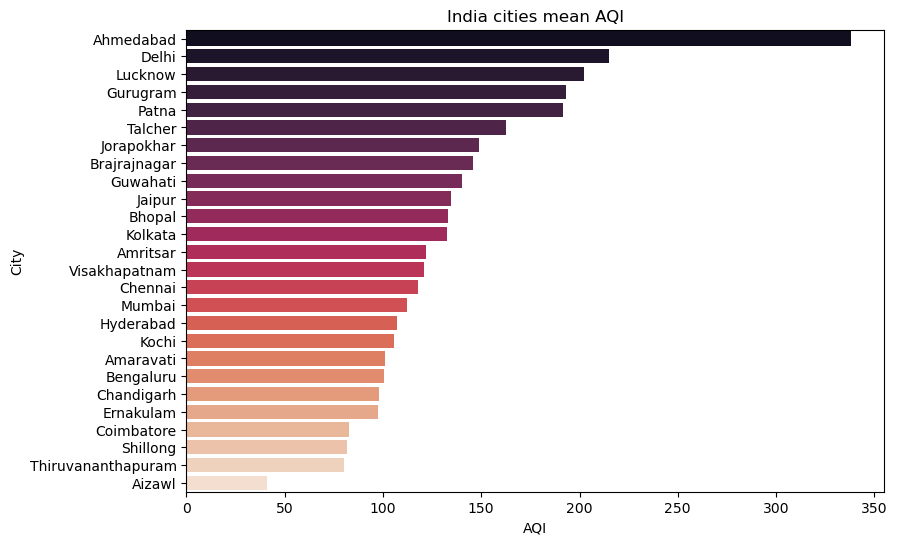

In [10]:
#plot the city with highest mean AQI for the last measurement 

x = df.groupby('City').mean().sort_values('AQI', ascending = False)['AQI']
x=x.reset_index('City')

plt.figure(figsize=(9,6))
sns.barplot(data=x,x='AQI',y='City',orient='h',palette='rocket')
plt.title('India cities mean AQI' )
plt.show()

In [11]:
#Show which station belong to which city as well as their total number of stations
y = pd.DataFrame(data=df.groupby('City')['StationId'].unique())
y['Total'] = y['StationId'].map(lambda x: len(x))
y.sort_values('Total', ascending = False)


,StationId,Total
City,,
Delhi,"[DL001, DL002, DL003, DL004, DL005, DL006, DL0...",38
Bengaluru,"[KA002, KA003, KA004, KA005, KA006, KA007, KA0...",10
Mumbai,"[MH005, MH006, MH007, MH008, MH009, MH010, MH0...",10
Kolkata,"[WB007, WB008, WB009, WB010, WB011, WB012, WB013]",7
Patna,"[BR005, BR006, BR007, BR008, BR009, BR010]",6
Hyderabad,"[TG001, TG002, TG003, TG004, TG005, TG006]",6
Lucknow,"[UP012, UP013, UP014, UP015, UP016]",5
Chennai,"[TN001, TN002, TN003, TN004]",4
Gurugram,"[HR011, HR012, HR013, HR014]",4


Most of the stations are in five cities which are also among the biggest cities of India 

C:\Users\Florian\AppData\Local\Temp\ipykernel_18056\308020509.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


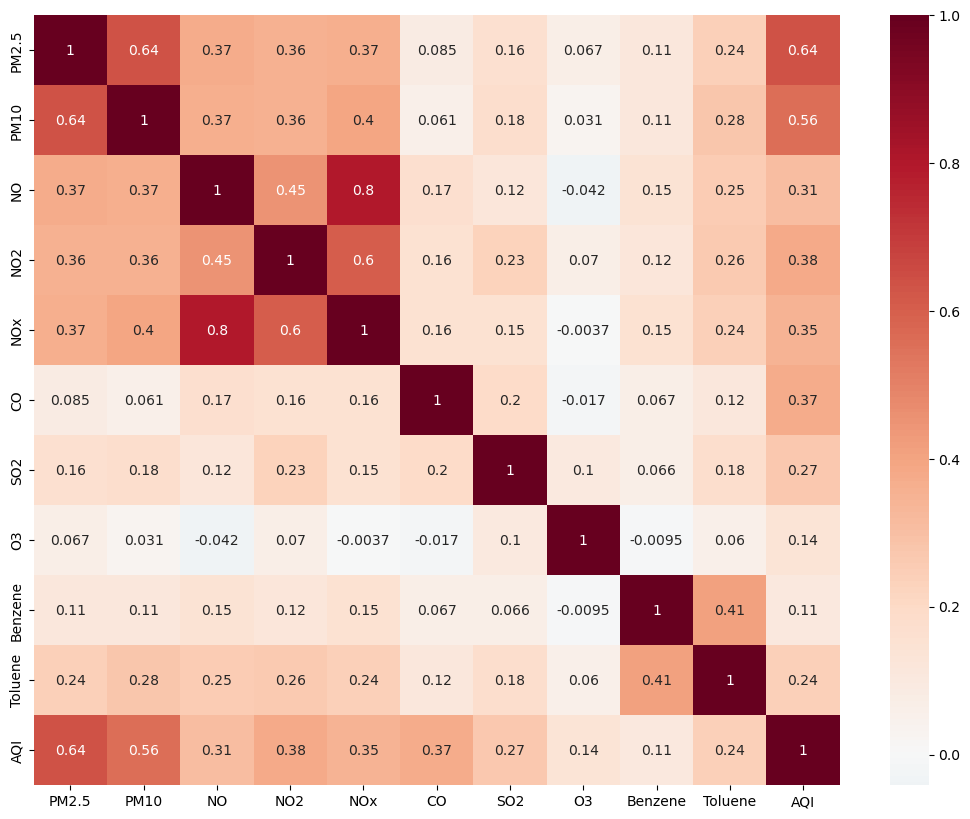

In [12]:
#plot correlations between variables 
corr = df.corr()
plt.figure(figsize=(13,10))
sns.heatmap(corr,annot=True,cmap='RdBu_r', center =0)
plt.show()

PM2.5 and PM10 have the higher impact on AQI and 03 and Benzene the least

# III - Machine Learning 

In [35]:
#function to display MAE RMSE MAPE and r2 metrics 

def calculate_scores(y_true,y_pred):

    res = pd.DataFrame(index=["MAE","RMSE","MAPE","r2"], 
                       data = [mean_absolute_error(y_true,y_pred),
                               np.sqrt(mean_squared_error(y_true, y_pred)),
                                mean_absolute_percentage_error(y_true, y_pred),
                                 r2_score(y_true,y_pred)])
    res.columns = ['Score']
    return res

In [36]:
#Encoding AQI bucket 
le=LabelEncoder()

df_2['AQI_Bucket']=le.fit_transform(df_2['AQI_Bucket'].astype(str))

df['AQI_Bucket']=le.fit_transform(df['AQI_Bucket'].astype(str))

In [37]:
#show real and encoded values 
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'Good': 0, 'Moderate': 1, 'Poor': 2, 'Satisfactory': 3, 'Severe': 4, 'Very Poor': 5}


In [38]:
#function to choose a station and resample data 
def station_resample (station_Id, resample_time):  #use to preprocess df (hourly data file)
    """ Select a or all station among :
        ['AP001', 'AP005', 'AS001', 'BR005', 'BR006', 'BR007', 'BR008','BR009', 'BR010', 'CH001', 'DL001', 'DL002', 'DL003', 'DL004',
       'DL005', 'DL006', 'DL007', 'DL008', 'DL009', 'DL010', 'DL011',DL012', 'DL013', 'DL014', 'DL015', 'DL016', 'DL017', 'DL018',
       'DL019', 'DL020', 'DL021', 'DL022', 'DL023', 'DL024', 'DL025', 'DL026', 'DL027', 'DL028', 'DL029', 'DL030', 'DL031', 'DL032',
       'DL033', 'DL034', 'DL035', 'DL036', 'DL037', 'DL038', 'GJ001','HR011', 'HR012', 'HR013', 'HR014', 'JH001', 'KA002', 'KA003',
       'KA004', 'KA005', 'KA006', 'KA007', 'KA008', 'KA009', 'KA010', 'KA011', 'KL002', 'KL004', 'KL007', 'KL008', 'MH005', 'MH006',
       'MH007', 'MH008', 'MH009', 'MH010', 'MH011', 'MH012', 'MH013', 'MH014', 'ML001', 'MP001', 'MZ001', 'OD001', 'OD002', 'PB001',
       'RJ004', 'RJ005', 'RJ006', 'TG001', 'TG002', 'TG003', 'TG004','TG005', 'TG006', 'TN001', 'TN002', 'TN003', 'TN004', 'TN005',
       'UP012', 'UP013', 'UP014', 'UP015', 'UP016', 'WB007', 'WB008','WB009', 'WB010', 'WB011', 'WB012', 'WB013'],

        AND resample  the dataset daily('D'), weekly('W'), monthly('M') or not('No') and split into training set """
    
    df_ML=df.drop(['City','State','Status','StationName'], axis = 1) #removing useless column for Model

    if station_Id in df.StationId.unique():
        df_stations = df_ML.groupby('StationId')
        df_stations = df_stations.get_group(station_Id)
        df_stations.set_index('Datetime', inplace = True)
        df_stations.drop(['StationId'],axis=1,inplace=True)   
                   
    
    elif station_Id == 'all':
        df_stations = df_ML.set_index('Datetime')
        
        df_stations.drop(['StationId'],axis=1,inplace=True)  

    if resample_time == 'No':
        df_resample = df_stations
        
    elif resample_time == 'D':
        df_resample = df_stations.resample('D').mean()  

    elif resample_time == 'M':
        df_resample = df_stations.resample('M').mean() 

    elif resample_time == 'W':
        df_resample = df_stations.resample('W').mean()

    Train =df_resample.head(round(len(df_resample)*80/100))     #the data is not split randomly to be used for ARIMA training later  
    Test = df_resample.tail(len(df_resample)-round(len(df_resample)*80/100))
    X_train, y_train = Train.drop(['AQI'],axis=1), Train['AQI']
    X_test, y_test = Test.drop(['AQI'],axis=1), Test['AQI']     

    return df_resample, Train, Test, X_train, X_test, y_train, y_test 
        
def preprocess(station_Id): #use to preprocess data from df_2 (daily data file)
    
    if station_Id in df_2.StationId.unique():
        df_stations = df_2.groupby('StationId')
        df_stations = df_stations.get_group(station_Id)
        df_stations.set_index('Date', inplace = True)
        df_stations.drop(['StationId'],axis=1,inplace=True)   
                   
    
    elif station_Id == 'all':
        df_stations = df_2.set_index('Date')
        
        df_stations.drop(['StationId'],axis=1,inplace=True)  
      

    
    Train =df_stations.head(round(len(df_stations)*80/100))      
    Test = df_stations.tail(len(df_stations)-round(len(df_stations)*80/100))
    X_train, y_train = Train.drop(['AQI'],axis=1), Train['AQI']
    X_test, y_test = Test.drop(['AQI'],axis=1), Test['AQI']     

    return df_stations, Train, Test, X_train, X_test, y_train, y_test 

    


## SVR on Daily data (df_2)

In [11]:
#Spliting daily dataframe into training samples
data, Train, Test, X_train, X_test, y_train, y_test = preprocess('all')

In [12]:
#Try Support Vector Regression with GridSearch 
params = { 'C': np.arange(2,9,1),
          'kernel': ['linear', 'rbf'],
          'epsilon': np.arange(0.1, 0.5, 0.1),
          'max_iter':[1000]}

model = SVR()

cv = GridSearchCV(model, param_grid = params )
cv.fit(X_train, y_train)



i:\Anaconda\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
i:\Anaconda\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
i:\Anaconda\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
i:\Anaconda\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
i:\Anaconda\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or M

GridSearchCV(estimator=SVR(),
             param_grid={'C': [8], 'epsilon': [0.4], 'kernel': ['rbf'],
                         'max_iter': [1000]})

In [54]:
#Saving model
filename = 'SVR_model_best_param_daily.sav'
pickle.dump(cv, open(filename, 'wb'))

In [13]:
y_pred = cv.predict(X_test)
pred = pd.DataFrame(data=y_pred, index=y_test.index)

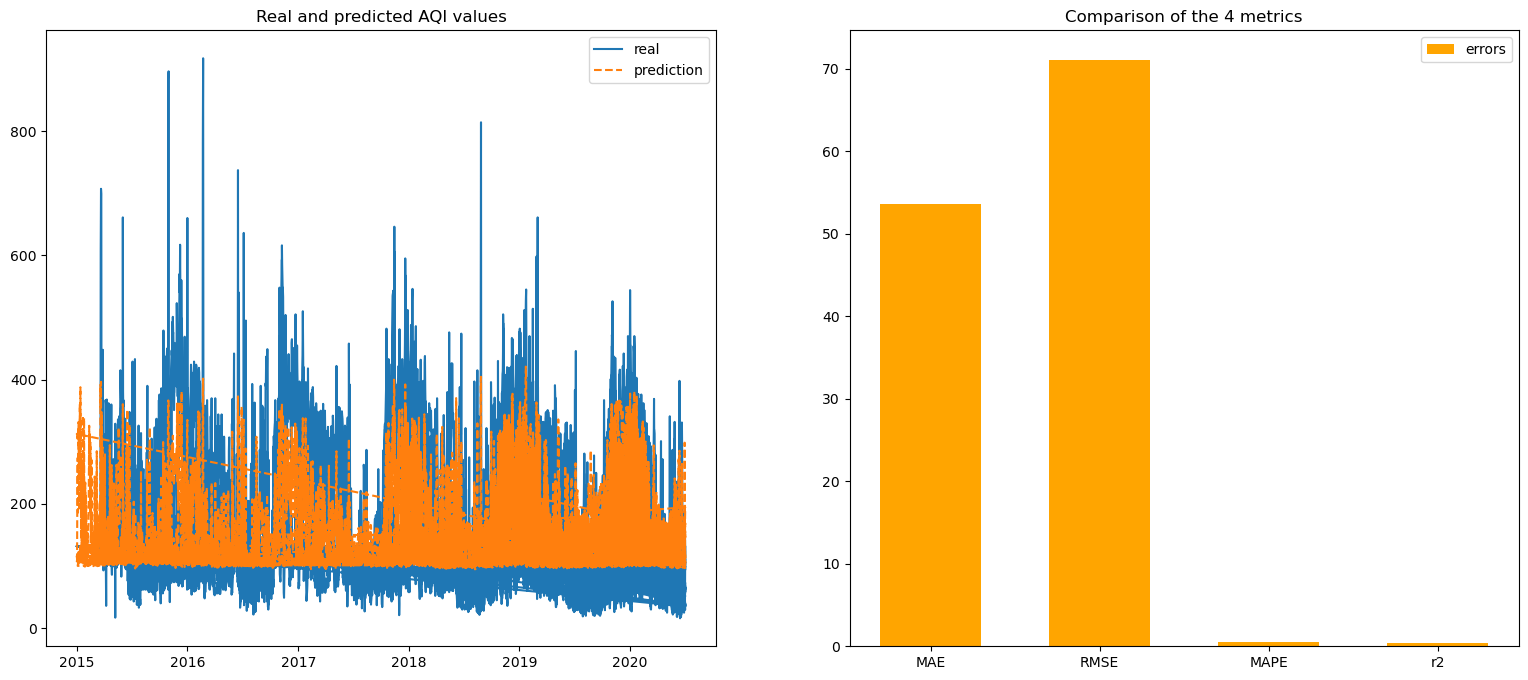

In [14]:
#Plot curves 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(19, 8))
ax1.plot(y_test,label='real')
ax1.plot(pred,'--',label='prediction')
ax1.set_title('Real and predicted AQI values')
ax1.legend()

#Plot errors
score = calculate_scores(y_test,y_pred)
ax2.bar(range(4),score['Score'],width=0.6, label = 'errors',color='orange')
ax2.set_title('Comparison of the 4 metrics')
ax2.legend()
ax2.set_xticks(range(4), labels=['MAE', 'RMSE', 'MAPE', 'r2'])

plt.show()

In [15]:
#Obtain the AQI Bucket from the AQI prediction
bucket = pred
bucket.columns =['Bucket_pred']
   
bucket['Bucket_pred'] =  bucket['Bucket_pred'].map(lambda x: get_AQI_bucket(x)) 
bucket['real_bucket'] = Test['AQI_Bucket'].map(lambda x: round(x))
bucket['Bucket_pred']=bucket['Bucket_pred'].replace(['Good','Moderate','Poor','Satisfactory','Severe','Very Poor'],[0,1,2,3,4,5])

pd.crosstab(bucket.real_bucket,bucket.Bucket_pred)

Bucket_pred,1,2,3,4,5
real_bucket,,,,,
0,1517,34,63,0,0
1,8915,336,108,0,74
2,1391,232,1,0,69
3,6192,35,392,0,2
4,15,232,0,3,157
5,733,963,0,0,143


In [16]:
print(classification_report(bucket.real_bucket,bucket.Bucket_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1614
           1       0.48      0.95      0.63      9433
           2       0.13      0.14      0.13      1693
           3       0.70      0.06      0.11      6621
           4       1.00      0.01      0.01       407
           5       0.32      0.08      0.13      1839

    accuracy                           0.45     21607
   macro avg       0.44      0.20      0.17     21607
weighted avg       0.48      0.45      0.33     21607



i:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
i:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
i:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVR on hourly data

In [39]:
#new training on hourly df without resample for one station
daily, Train_D, Test_D, X_train, X_test, y_train, y_test = station_resample('AP001','No')

params = { 'C': np.arange(2,9,1),
          'kernel': ['linear', 'rbf'],
          'epsilon': np.arange(0.1, 0.5, 0.1),
          'max_iter':[1000]}
model = SVR()

cv = GridSearchCV(model, param_grid = params )
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

pred = pd.DataFrame(data=y_pred, index=y_test.index)

C:\Users\Florian\AppData\Local\Temp\ipykernel_4028\1505911232.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop(['StationId'],axis=1,inplace=True)


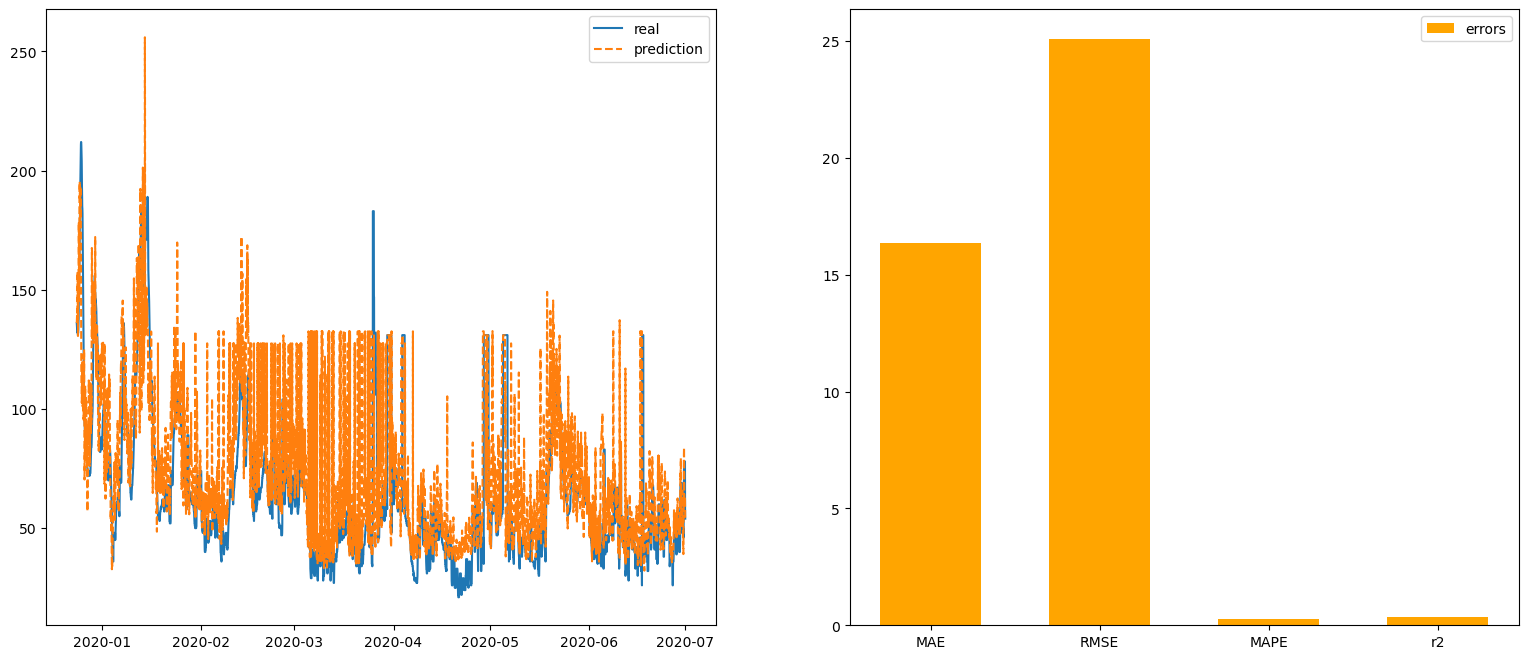

In [40]:
#Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(19, 8))
ax1.plot(y_test,label='real')
ax1.plot(pred,'--',label='prediction')
ax1.legend()

#Plot errors
score = calculate_scores(y_test,y_pred)
ax2.bar(range(4),score['Score'],width=0.6, label = 'errors',color='orange')
ax2.legend()
ax2.set_xticks(range(4), labels=['MAE', 'RMSE', 'MAPE', 'r2'])

plt.show()

In [44]:
#Obtain the AQI Bucket from the AQI prediction
bucket = pred
bucket.columns =['Bucket_pred']
   
bucket['Bucket_pred'] = bucket['Bucket_pred'].map(lambda x: get_AQI_bucket(x)) 
bucket['real_bucket'] = Test_D['AQI_Bucket'].map(lambda x: round(x))
bucket['Bucket_pred']=bucket['Bucket_pred'].replace(['Good','Moderate','Poor','Satisfactory','Severe','Very Poor'],[0,1,2,3,4,5])

pd.crosstab(bucket.real_bucket,bucket.Bucket_pred)

Bucket_pred,0,1,2,3
real_bucket,,,,
0,980,84,0,729
1,32,375,3,134
2,0,10,0,0
3,72,331,0,1807


In [45]:
print(classification_report(bucket.real_bucket,bucket.Bucket_pred))

              precision    recall  f1-score   support

           0       0.90      0.55      0.68      1793
           1       0.47      0.69      0.56       544
           2       0.00      0.00      0.00        10
           3       0.68      0.82      0.74      2210

    accuracy                           0.69      4557
   macro avg       0.51      0.51      0.49      4557
weighted avg       0.74      0.69      0.69      4557



In [ ]:
#new training on hourly df resample daily
daily, Train_D, Test_D, X_train, X_test, y_train, y_test = station_resample('AP001','D')

params = { 'C': np.arange(2,9,1),
          'kernel': ['linear', 'rbf'],
          'epsilon': np.arange(0.1, 0.5, 0.1),
          'max_iter':[1000]}
model = SVR()

cv = GridSearchCV(model, param_grid = params )
cv.fit(X_train, y_train)
y_pred = cv.predict(X_test)

pred = pd.DataFrame(data=y_pred, index=y_test.index)

In [ ]:
#Saving model ==> model used for the API (same as SVR_model_best_param.sav)
#filename = 'SVR_model_best_param_hourly.sav'
#pickle.dump(cv, open(filename, 'wb'))

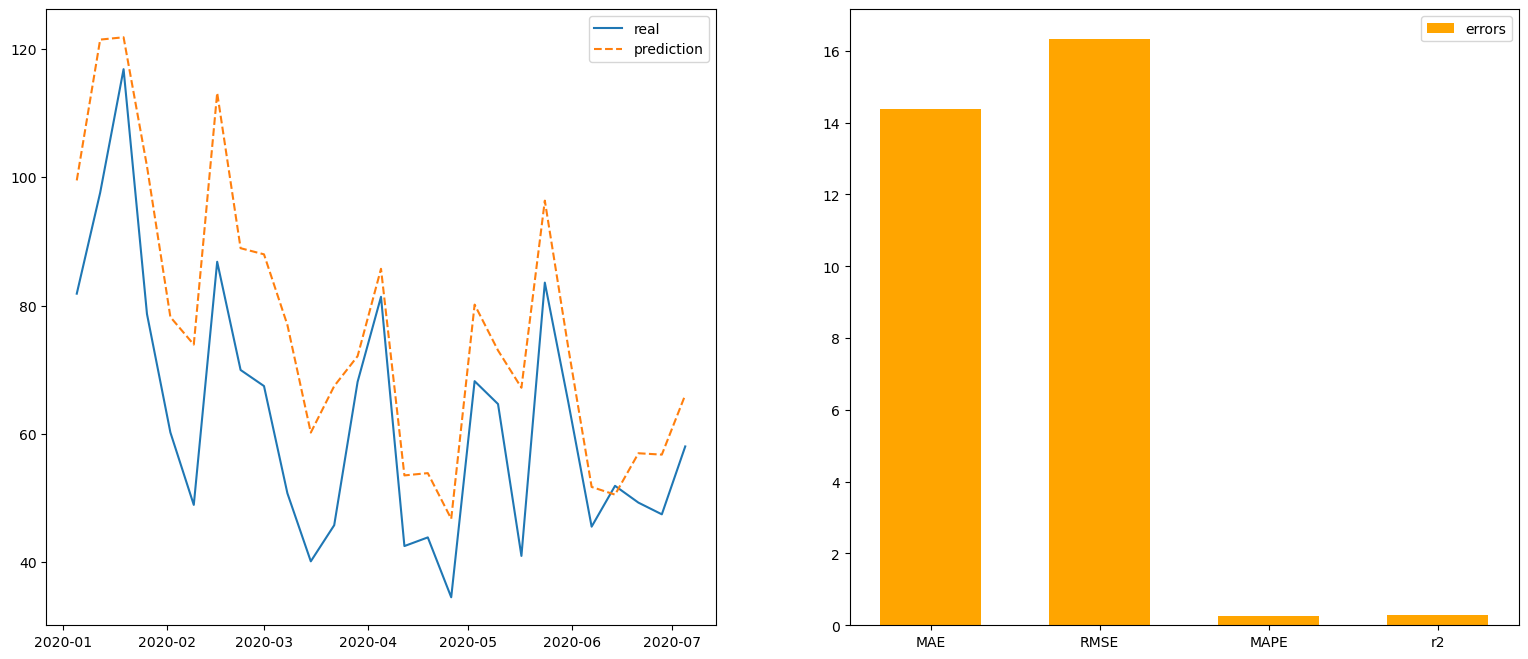

In [16]:
#Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(19, 8))
ax1.plot(y_test,label='real')
ax1.plot(pred,'--',label='prediction')
ax1.legend()

#Plot errors
score = calculate_scores(y_test,y_pred)
ax2.bar(range(4),score['Score'],width=0.6, label = 'errors',color='orange')
ax2.legend()
ax2.set_xticks(range(4), labels=['MAE', 'RMSE', 'MAPE', 'r2'])

plt.show()

# IV - Stat models (all this part was not implemented in the api because of time limit)

## Exploration

In [17]:

#resample the data Daily,weekly and monthly for a faster training

weekly, Train_W, Test_W, X_train, X_test, y_train, y_test = station_resample('AP001','W')
monthly, Train_M, Test_M, X_train, X_test, y_train, y_test = station_resample('AP001','M')
daily, Train_D, Test_D, X_train, X_test, y_train, y_test = station_resample('AP001','D')

C:\Users\Florian\AppData\Local\Temp\ipykernel_19344\4000358707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop(['StationId'],axis=1,inplace=True)
C:\Users\Florian\AppData\Local\Temp\ipykernel_19344\4000358707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations.drop(['StationId'],axis=1,inplace=True)
C:\Users\Florian\AppData\Local\Temp\ipykernel_19344\4000358707.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [18]:

result = sm.tsa.stattools.adfuller(daily['AQI'].values)
print('p-value=',result[1])

p-value= 0.004689744848505239


The p-value is <5%, the time series is stationary 

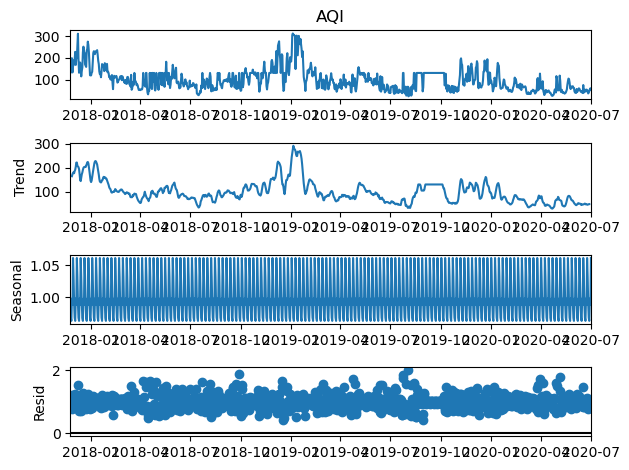

In [19]:
res = seasonal_decompose(daily['AQI'], model='multiplicative')
res.plot()
plt.show()

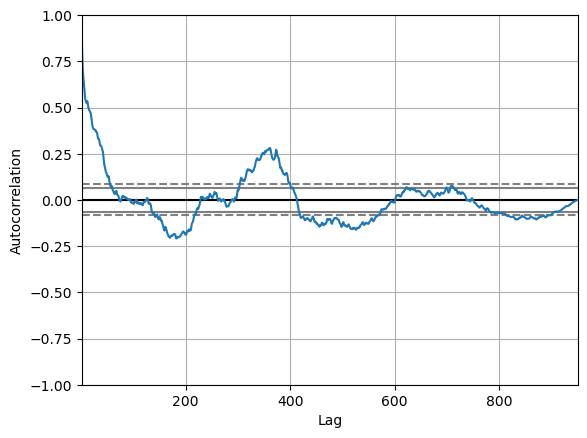

In [20]:
pd.plotting.autocorrelation_plot(daily['AQI'])
plt.show()

i:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


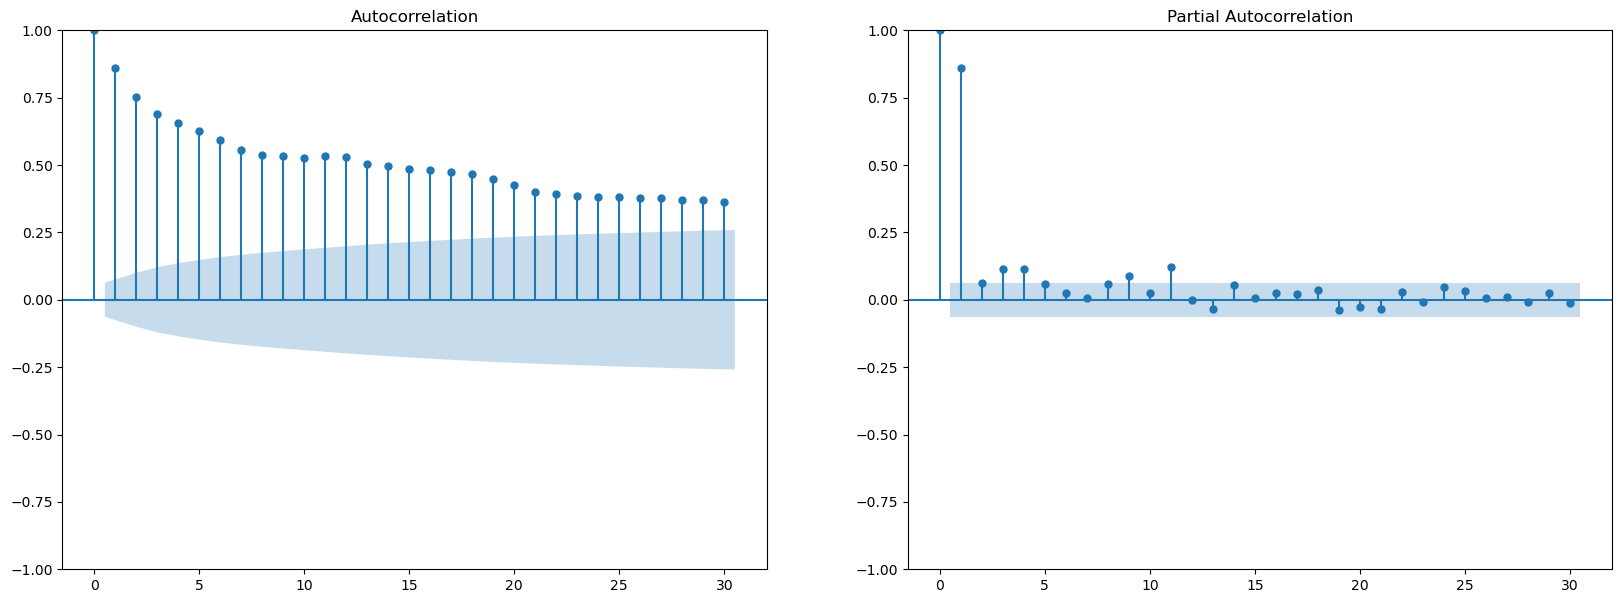

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,7))
plot_acf(daily['AQI'], ax=ax1)
plot_pacf(daily['AQI'], ax=ax2)
plt.show()

## SARIMA

### Predictions

In [22]:
#for those predictions we only need the target column: AQI
weekly_sarima=weekly['AQI']
monthly_sarima=monthly['AQI']
daily_sarima = daily['AQI']


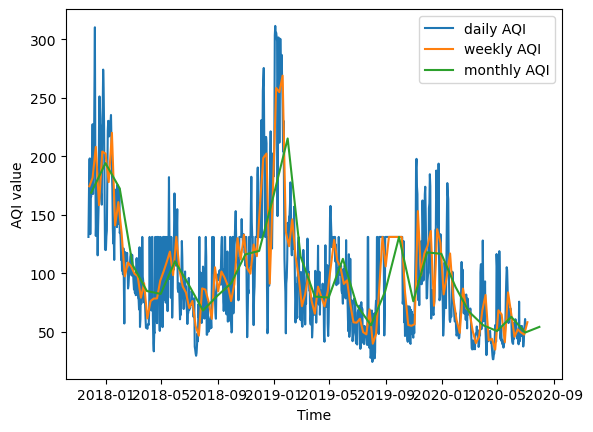

In [23]:
plt.plot(daily_sarima,label='daily AQI')
plt.plot(weekly_sarima,label='weekly AQI')
plt.plot(monthly_sarima,label='monthly AQI')
plt.xlabel('Time')
plt.ylabel('AQI value')
plt.legend()

plt.show()

In [24]:
#Splitting the data into training and test samples

Train_sarima_W, Test_sarima_W = Train_W['AQI'], Test_W['AQI']

Train_sarima_M, Test_sarima_M =Train_M['AQI'], Test_M['AQI']

Train_sarima_D, Test_sarima_D =Train_D['AQI'], Test_D['AQI']


In [143]:
#parameters screening

#p_values = range(0, 2)
#d_values = range(0, 2)
#q_values = range(0, 3)
#best_score = float("inf")
#best_params = (0,0,0)
#for p in p_values:
#   for d in d_values:
#       for q in q_values:
#           for P in p_values:
#               for Q in q_values:
#                   for D in d_values:
#                    order = (p,d,q)
#                    seasonal_order = (P,D,Q,52)
#                    warnings.filterwarnings("ignore")
#                    model = sm.tsa.arima.ARIMA(Train_sarima_W, order=order, seasonal_order = seasonal_order).fit()
#                    predictions = model.predict(Test_sarima_W.index[0], Test_sarima_W.index[-1])
#                    error = mean_absolute_error(Test_sarima_W, predictions)
#                    if error < best_score:
#                        best_score = error
#                        best_params = order
#                        best_season = seasonal_order 
#
#print(best_params, best_score, best_season)

(0, 1, 0) 28.818413865496098 (1, 0, 0, 52)


In [ ]:
#saving best parameters 

best_params_weekly = '(2, 0, 1) (2, 1, 1, 52)'
best_params_monthly = '(0,1, 0) (1, 0, 1, 12)'

In [25]:
#create models with best params on Training sample
model_W = sm.tsa.SARIMAX(Train_sarima_W, order = (2,0,1), seasonal_order = (2,1,1,52))
model_M = sm.tsa.SARIMAX(Train_sarima_M, order = (0,1,0), seasonal_order = (1,0,1,12))

In [26]:
#fitting the model
sarima_W = model_W.fit()
sarima_M = model_M.fit()

i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
i:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
i:\Anaconda\lib\site-packages\statsmodels\tsa\st

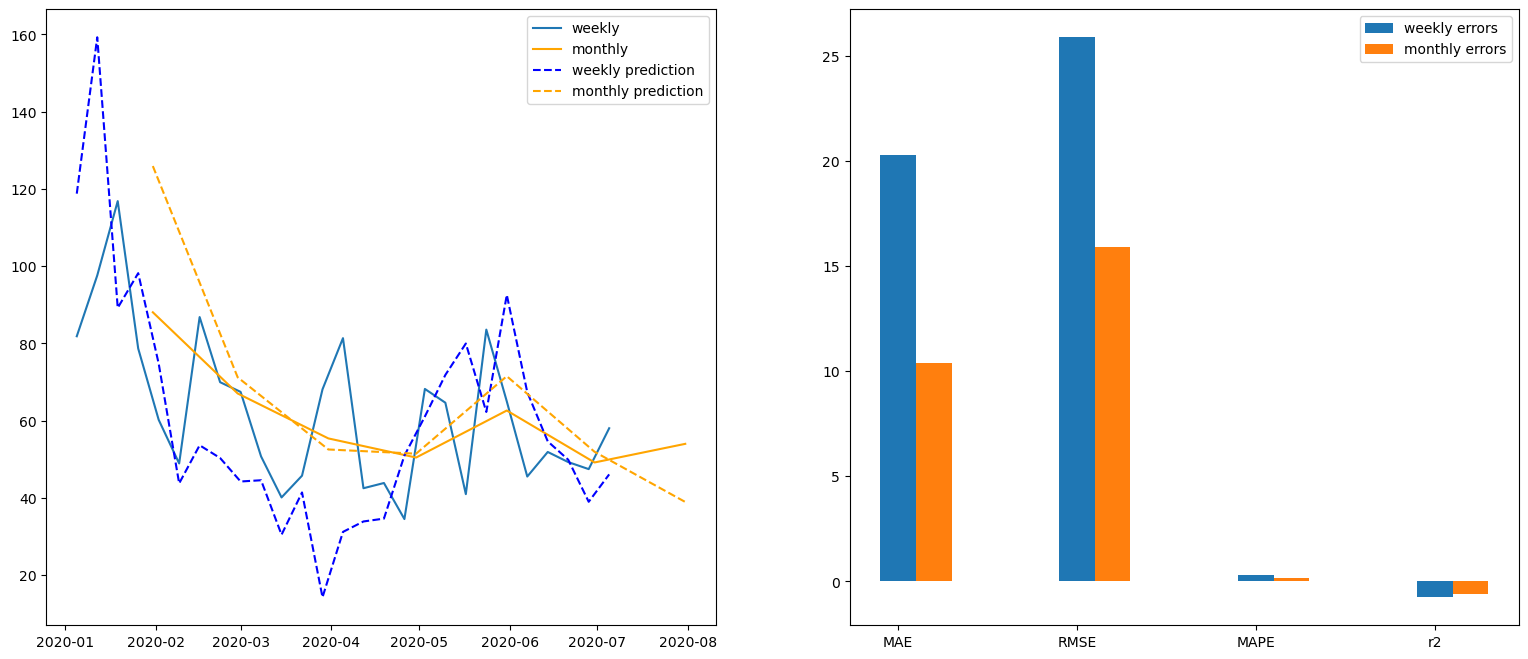

In [34]:
#get predictions
pred_W = sarima_W.predict(Test_sarima_W.index[0],Test_sarima_W.index[-1])
pred_M = sarima_M.predict(Test_sarima_M.index[0],Test_sarima_M.index[-1])

#Plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(19, 8))
#Plot prediction
ax1.plot(Test_sarima_W, label='weekly')
ax1.plot(Test_sarima_M, label ='monthly',color='orange')
ax1.plot(pred_W, '--', label ='weekly prediction',color='blue')
ax1.plot(pred_M, '--', label = 'monthly prediction',color='orange')

ax1.legend()

#Plot errors
#D_score = calculate_scores(Test['AQI'],pred_D)
W_score = calculate_scores(Test_sarima_W,pred_W)
M_score = calculate_scores(Test_sarima_M,pred_M)
#ax2.bar([-0.2,0.8,1.8,2.8],D_score['Score'],width=0.2, label = 'daily errors')
ax2.bar(range(4),W_score['Score'],width=0.2, label = 'weekly errors')
ax2.bar([0.2,1.2,2.2,3.2],M_score['Score'],width=0.2, label = 'monthly errors')
ax2.legend()
ax2.set_xticks(range(4), labels = W_score.index, minor=False)

plt.show()

### Forecast (in an ideal case this model would have been implemented in the api)

In [35]:
#Training on FULL dataset for forecast
model_W = sm.tsa.SARIMAX(weekly_sarima, order = (2,0,1), seasonal_order = (2,1,1,52))
model_M = sm.tsa.SARIMAX(monthly_sarima, order = (0,1,0), seasonal_order = (1,0,1,12))

In [36]:
sarima_W = model_W.fit()
sarima_M = model_M.fit()

i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
i:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
i:\Anaconda\lib\site-packages\statsmodels\tsa\st

In [37]:
#get forecast 
arima_W_forecast = sarima_W.get_forecast(steps=20).summary_frame()
arima_M_forecast = sarima_M.get_forecast(steps=5).summary_frame()

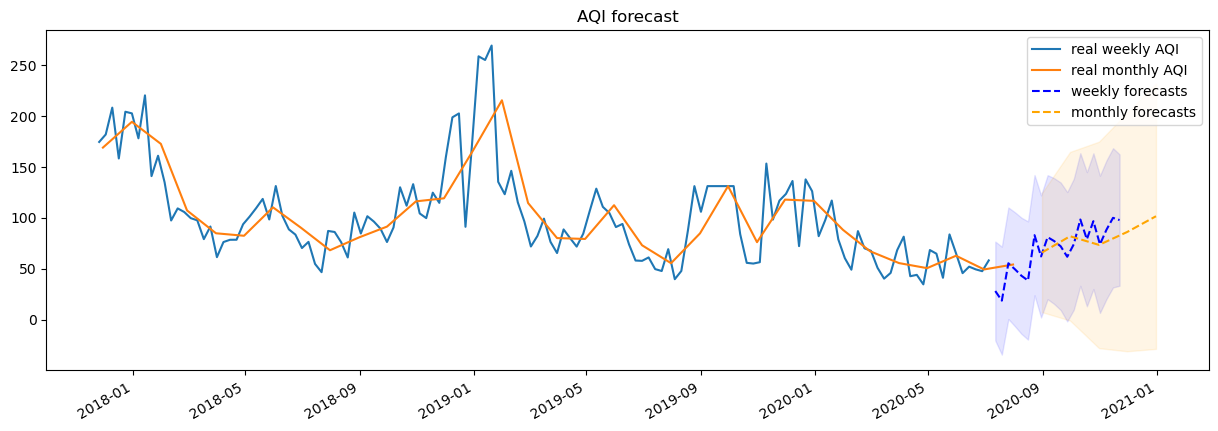

In [38]:
fig, ax = plt.subplots(figsize = (15,5))

plt.plot(weekly_sarima, label = 'real weekly AQI')
plt.plot(monthly_sarima, label = 'real monthly AQI')
arima_W_forecast['mean'].plot(ax = ax, style = 'b--', label = 'weekly forecasts') 
arima_M_forecast['mean'].plot(ax = ax, style = '--', label = 'monthly forecasts', color='orange') 

ax.fill_between(arima_W_forecast.index, arima_W_forecast['mean_ci_lower'], arima_W_forecast['mean_ci_upper'], color='b', alpha=0.1)
ax.fill_between(arima_M_forecast.index, arima_M_forecast['mean_ci_lower'], arima_M_forecast['mean_ci_upper'], color='orange', alpha=0.1)
plt.title('AQI forecast')
plt.legend()
plt.show()

## SARIMAX

In [39]:
#adding exog data for better precision

model_W = sm.tsa.SARIMAX(Train_sarima_W, order = (2,0,1), seasonal_order = (2,1,1,52),exog = Train_W.drop(['AQI','AQI_Bucket'],axis=1))
model_M = sm.tsa.SARIMAX(Train_sarima_M, order = (0,1,0), seasonal_order = (1,0,1,12),exog = Train_M.drop(['AQI','AQI_Bucket'],axis=1))

In [40]:
sarima_W = model_W.fit()
sarima_M = model_M.fit()

i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
i:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
i:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
i:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


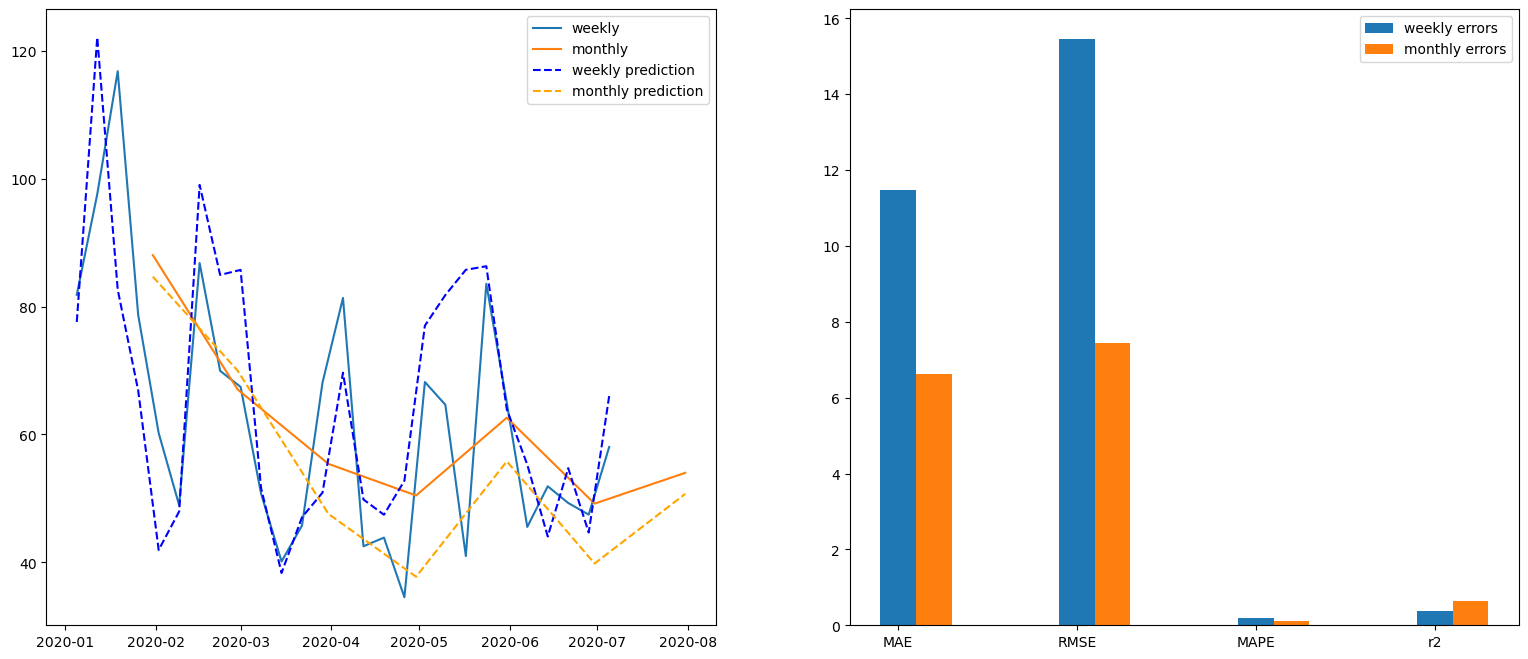

In [41]:
#make predictions: 

pred_W = sarima_W.predict(Test_sarima_W.index[0],Test_sarima_W.index[-1], exog=Test_W.drop(['AQI','AQI_Bucket'],axis=1))
pred_M = sarima_M.predict(Test_sarima_M.index[0],Test_sarima_M.index[-1], exog=Test_M.drop(['AQI','AQI_Bucket'],axis=1))

#Plot results 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(19, 8))
#Plot real data and prediction
ax1.plot(Test_sarima_W, label='weekly')
ax1.plot(Test_sarima_M, label ='monthly')
ax1.plot(pred_W, '--', label ='weekly prediction',color='b')
ax1.plot(pred_M, '--', label = 'monthly prediction', color='orange')
ax1.legend()

#Plot errors
#D_score = calculate_scores(Test['AQI'],pred_D)
W_score = calculate_scores(Test_sarima_W,pred_W)
M_score = calculate_scores(Test_sarima_M,pred_M)
#ax2.bar([-0.2,0.8,1.8,2.8],D_score['Score'],width=0.2, label = 'daily errors')
ax2.bar(range(4),W_score['Score'],width=0.2, label = 'weekly errors')
ax2.bar([0.2,1.2,2.2,3.2],M_score['Score'],width=0.2, label = 'monthly errors')
ax2.legend()
ax2.set_xticks(range(4), labels = W_score.index, minor=False)

plt.show()